In [3]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

In [4]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    'All': [("2023-03-26/_Bandlock_Udp_All_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-03-26/_Bandlock_Udp_All_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-03-26/_Bandlock_Udp_All_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-01/_Bandlock_Udp_B1B3_B1B8_LTE_All_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-10/_Bandlock_Udp_All_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-10/_Bandlock_Udp_All_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-10/_Bandlock_Udp_All_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-10/_Bandlock_Udp_LTE_All_B7B8_B7_RM500Q/qc01", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_B1B3_B3B7_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_B1B8_B3B8_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_B1_B3_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_B7_B8_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B1': [("2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(12)]),
           ("2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(6)]),
           ("2023-04-10/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(2)]),
           ("2023-04-17/_Bandlock_Udp_All_LTE_B1_B3_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B3': [("2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc01", ['#{:02d}'.format(i+1) for i in range(6)]),
           ("2023-04-17/_Bandlock_Udp_All_LTE_B1_B3_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B7': [("2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(12)]),
           ("2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(6)]),
           ("2023-04-10/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(2)]),
           ("2023-04-10/_Bandlock_Udp_LTE_All_B7B8_B7_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(2)]),
           ("2023-04-17/_Bandlock_Udp_All_LTE_B7_B8_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B8': [("2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(12)]),
           ("2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(6)]),
           ("2023-04-10/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(2)]),
           ("2023-04-17/_Bandlock_Udp_All_LTE_B7_B8_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B1B3': [("2023-04-01/_Bandlock_Udp_B1B3_B1B8_LTE_All_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(4)]),
             ("2023-04-17/_Bandlock_Udp_All_LTE_B1B3_B3B7_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B1B7': [("2023-04-17/_Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(4)]),
        ],
    'B1B8': [("2023-04-01/_Bandlock_Udp_B1B3_B1B8_LTE_All_RM500Q/qc01", ['#{:02d}'.format(i+1) for i in range(4)]),
             ("2023-04-17/_Bandlock_Udp_All_LTE_B1B8_B3B8_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(4)]),
        ],
    'B3B7': [("2023-04-17/_Bandlock_Udp_All_LTE_B1B3_B3B7_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(2)]),
        ],
    'B3B8': [("2023-04-17/_Bandlock_Udp_All_LTE_B1B8_B3B8_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(4)]),
        ],
    'B7B8': [("2023-04-10/_Bandlock_Udp_LTE_All_B7B8_B7_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(2)]),
             ("2023-04-17/_Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(4)]),
        ],
    'LTE': [("2023-04-01/_Bandlock_Udp_B1B3_B1B8_LTE_All_RM500Q/qc02", ['#{:02d}'.format(i+1) for i in range(4)]),
            ("2023-04-10/_Bandlock_Udp_LTE_All_B7B8_B7_RM500Q/qc00", ['#{:02d}'.format(i+1) for i in range(2)]),
            ("2023-04-17/_Bandlock_Udp_All_LTE_RM500Q/qc03", ['#{:02d}'.format(i+1) for i in range(4)]),
        ],
}

In [21]:
DD = {
    'All': [0, [], []],
    'B1': [0, [], []],
    'B3': [0, [], []],
    'B7': [0, [], []],
    'B8': [0, [], []],
    'B1B3': [0, [], []],
    'B1B7': [0, [], []],
    'B1B8': [0, [], []],
    'B3B7': [0, [], []],
    'B3B8': [0, [], []],
    'B7B8': [0, [], []],
    'LTE': [0, [], []],
}
Overall = [0, [], []]

for key, item in exps.items():
    print(key)
    for exp in item:
        for trace in exp[1]:
            ## read uplink
            data = os.path.join(datadir, exp[0], trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ulplr = sum(df_ul['lost']) / (len(df_ul) + 1e-9) * 100
            print(ulplr)
            ## read downlink
            data = os.path.join(datadir, exp[0], trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            dlplr = sum(df_dl['lost']) / (len(df_dl) + 1e-9) * 100
            print(dlplr)
            # fill in
            DD[key][0] += 1
            DD[key][1].append(ulplr)
            DD[key][2].append(dlplr)
            Overall[0] += 1
            Overall[1].append(ulplr)
            Overall[2].append(dlplr)

All
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#01/data/udp_uplk_loss_latency.csv True
0.013354433338007296
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
0.7752248552713236
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#02/data/udp_uplk_loss_latency.csv True
0.1676488153056881
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv True
0.5684230218519037
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#03/data/udp_uplk_loss_latency.csv True
0.20899627851787791
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#03/data/udp_dnlk_loss_latency.csv True
1.0692519281592074
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/_Bandlock_Udp_All_RM500Q/qc00/#04/data/udp_uplk_loss_latency.csv True
0.0338548419627162

In [28]:
from pprint import pprint
pprint(DD)
print(Overall)

{'All': [46,
         [0.013354433338007296,
          0.1676488153056881,
          0.20899627851787791,
          0.033854841962716216,
          0.19096839673350433,
          0.13167267468214985,
          0.07818292107568864,
          0.025211052525426967,
          0.12619939504416897,
          0.11663990668807382,
          0.07616094897890359,
          0.030973578816953132,
          0.04344217651788233,
          0.10450648928808412,
          0.030957305265376357,
          0.022442139097825848,
          0.04438173592204683,
          0.06493089497606074,
          0.14506865920788442,
          0.06136282554405951,
          0.5557653199790641,
          0.13342085360806996,
          0.019413966005475947,
          0.14564146498179378,
          0.06609248817564034,
          0.1880116553350896,
          0.03076838924063595,
          0.024146698294106615,
          0.09349717600366297,
          0.03464219560821774,
          0.025370712850265893,
          0.07230196

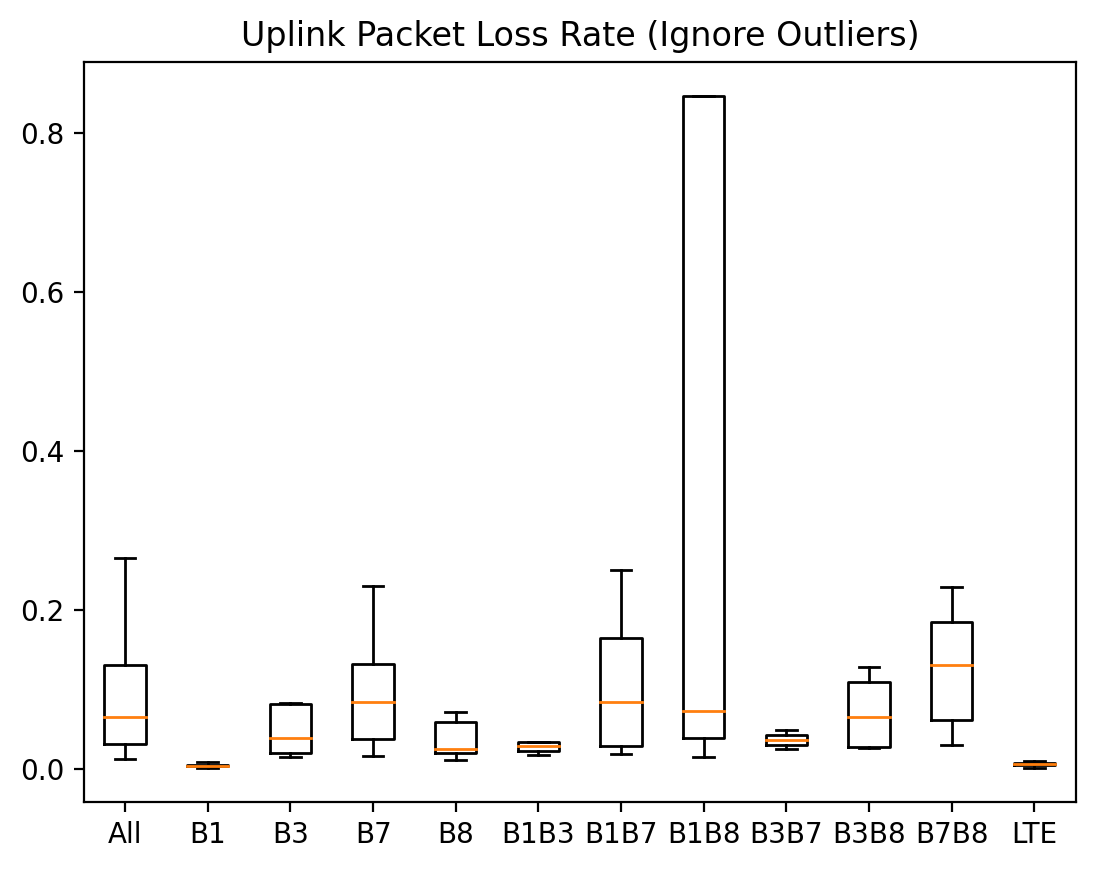

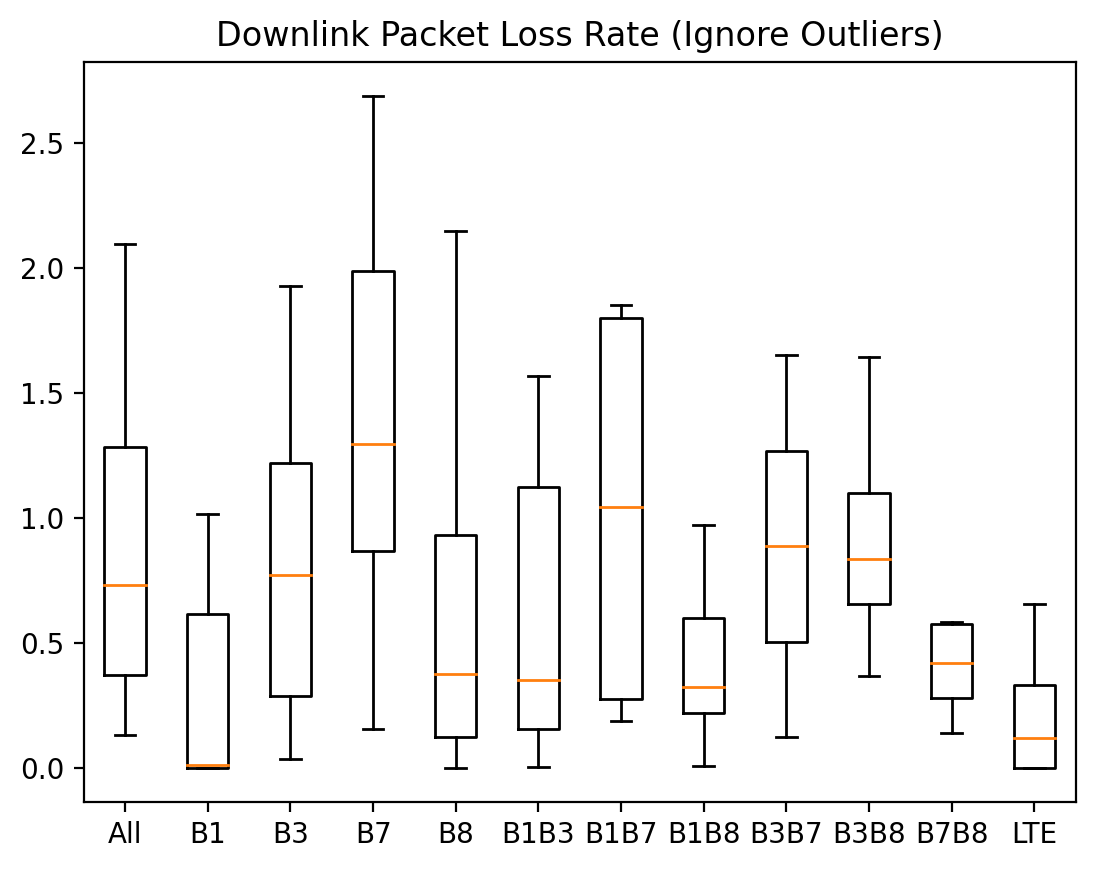

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

boxes = [DD['All'][1], DD['B1'][1], DD['B3'][1], DD['B7'][1], DD['B8'][1], DD['B1B3'][1], DD['B1B7'][1], DD['B1B8'][1], DD['B3B7'][1], DD['B3B8'][1], DD['B7B8'][1], DD['LTE'][1]]
labels = 'All', 'B1', 'B3', 'B7', 'B8', 'B1B3', 'B1B7', 'B1B8', 'B3B7', 'B3B8', 'B7B8', 'LTE'
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=False)
# plt.violinplot(boxes, labels=labels, showfliers=False)
plt.title('Uplink Packet Loss Rate (Ignore Outliers)')
plt.show()

###
boxes = [DD['All'][2], DD['B1'][2], DD['B3'][2], DD['B7'][2], DD['B8'][2], DD['B1B3'][2], DD['B1B7'][2], DD['B1B8'][2], DD['B3B7'][2], DD['B3B8'][2], DD['B7B8'][2], DD['LTE'][2]]
labels = 'All', 'B1', 'B3', 'B7', 'B8', 'B1B3', 'B1B7', 'B1B8', 'B3B7', 'B3B8', 'B7B8', 'LTE'
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=False)
# plt.violinplot(boxes, labels=labels, showfliers=False)
plt.title('Downlink Packet Loss Rate (Ignore Outliers)')
plt.show()

In [27]:
ul_plrs = sorted(Overall[1])
ul_upper_thr = np.percentile(ul_plrs, 75)
ul_lower_thr = np.percentile(ul_plrs, 25)
print(ul_upper_thr, ul_lower_thr)

dl_plrs = sorted(Overall[2])
dl_upper_thr = np.percentile(dl_plrs, 75)
dl_lower_thr = np.percentile(dl_plrs, 25)
print(dl_upper_thr, dl_lower_thr)

import csv

with open('data_classify.csv', 'w') as f:
    csv_writer = csv.writer(f)
    # csv_writer.writerow()
    for key in ['All', 'B1', 'B3', 'B7', 'B8', 'B1B3', 'B1B7', 'B1B8', 'B3B7', 'B3B8', 'B7B8', 'LTE']:
        num = DD[key][0]
        ul_bad = [s for s in DD[key][1] if s > ul_upper_thr]
        ul_good = [s for s in DD[key][1] if s < ul_lower_thr]
        dl_bad = [s for s in DD[key][2] if s > dl_upper_thr]
        dl_good = [s for s in DD[key][2] if s < dl_lower_thr]
        print(key, num, num-len(ul_bad)-len(ul_good), len(ul_bad), len(ul_good), num-len(dl_bad)-len(dl_good), len(dl_bad), len(dl_good))
        csv_writer.writerow([key, num, num-len(ul_bad)-len(ul_good), len(ul_bad), len(ul_good), num-len(dl_bad)-len(dl_good), len(dl_bad), len(dl_good)])

0.10307416343232631 0.018307157642902874
1.1675135962154477 0.1840681851796131
All 46 27 16 3 28 14 4
B1 22 3 0 19 9 0 13
B3 8 5 1 2 4 2 2
B7 24 15 8 1 8 14 2
B8 22 14 4 4 12 3 7
B1B3 6 4 1 1 2 2 2
B1B7 4 2 2 0 2 2 0
B1B8 8 4 3 1 5 1 2
B3B7 2 2 0 0 0 1 1
B3B8 4 2 2 0 3 1 0
B7B8 6 2 4 0 4 1 1
LTE 10 0 0 10 3 0 7
